# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [344]:
import os

import pickle
import time

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model, dummy

from sklearn.svm import LinearSVR, SVR
from sklearn import kernel_ridge
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [345]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [346]:
def print_listdir( path=None, level=0, exclude=[] ) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 devel
 |- Exploration_v0 (copy).ipynb
 |- Exploration_v0.ipynb
 |- Modelisation_energy_v0.ipynb
 |- hist_quantile.ipynb
 |- kmeans.ipynb
 |- pipeline.ipynb
 |- regressor.ipynb
 install_packages_venv.sh


Chargement des données

In [347]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype = pd.read_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location = pd.read_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)
df_annexe = pd.read_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)

print('df:', df.shape)
print('df_hotencoding_usetype:', df_hotencoding_usetype.shape)
print('df_hotencoding_location:', df_hotencoding_location.shape)
print('df_annexe:', df_annexe.shape)
print('df columns:', df.columns.tolist())

df: (1549, 11)
df_hotencoding_usetype: (1549, 18)
df_hotencoding_location: (1549, 13)
df_annexe: (1549, 7)
df columns: ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', '%GFABuilding(s)', 'SiteEUIWN(kBtu/sf)', '% SteamUse', '% Electricity', '% NaturalGas', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)']


In [348]:
to_drop = [ 'GHGEmissionsIntensity', 'Outlier' ]

df.drop( columns=to_drop, inplace=True )

n_continuous = df.shape[1] -1

df = pd.concat( (df, df_hotencoding_location, df_hotencoding_usetype), axis=1 )
print('df shape:', df.shape)

sr_loc = df.isna().sum(1) == 0

df = df.loc[ sr_loc, :]

target = 'SiteEUIWN(kBtu/sf)'
y = df[target]
df.drop( columns=target, inplace=True )

print('df shape:', df.shape)
print('y shape:', y.shape)


df.head()

df shape: (1549, 40)
df shape: (1549, 39)
y shape: (1549,)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFABuilding(s),% SteamUse,% Electricity,% NaturalGas,AgeOfBuilding(s),ballard,central,delridge,downtown,east,greater duwamish,lake union,magnolia / queen anne,north,northeast,northwest,southeast,southwest,data center,education,entertainment/public assembly,industrial,lifestyle center,medical,medical office,office,other,other - entertainment/public assembly,residential - hotel,restaurant,science,self-storage facility,services,store,utility,worship facility
0,1.0,12,88434,1.000000,0.277302,0.546060,0.176638,89,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,11,103566,0.854547,0.000000,0.386609,0.613391,20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809918,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,41,956110,0.794252,0.297113,0.682307,0.020579,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,10,61320,1.000000,0.325913,0.407519,0.266567,90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,18,175580,0.646885,0.000000,0.378802,0.621198,36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644776,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Transformer
<span style="color:red"> FAIRE UN TRANSFORMER AVEC PLUSIUERS MODES: </span>
- identiy
- log
- ... ?

call fit
out y.min(): 0.699999988
out y.min(): 0.699999988
call transform


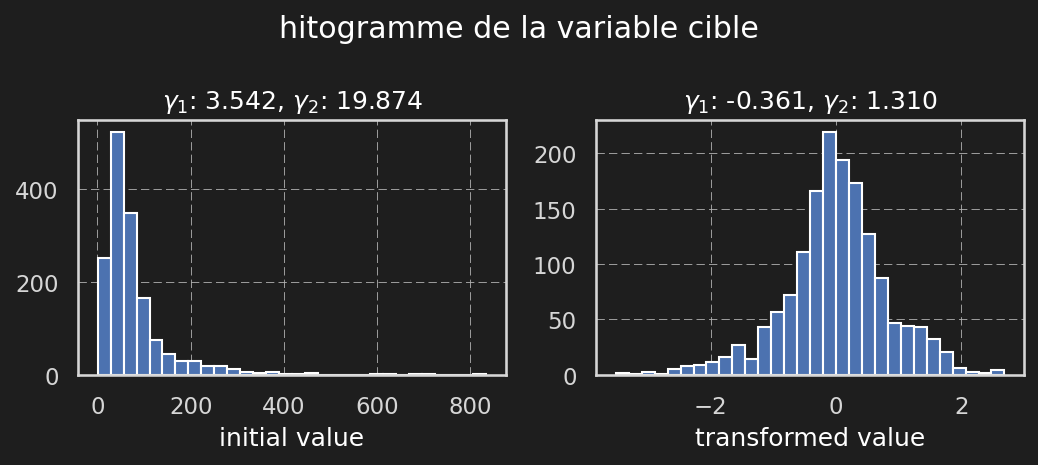

In [349]:
class Transformer:
    def __init__( self, type='identity', power=1 ):
        self.type = type
        self.cst = 0.
        self.coef = 1.
        self.y_min = 0.
        if type == 'power':
            self.power = power
        return
    def get_dico_func(self):
        return {'func':self.transform, 'inverse_func':self.reverse }
    def fit( self, y ):
        if self.type == 'identity':
            return self
        if self.type == 'log':
            self.y_min = 1 - min( y.min(), 0)
            self.cst = -np.log(y+self.y_min).mean()
            return self
        if self.type == 'loglog':
            self.y_min = 1 - min( y.min(), 0)
            self.cst = -np.log(np.log(y+self.y_min)).mean()
            return self
        if self.type == 'power':
            self.y_min = 1 - min( y.min(), 0)
            self.cst = -((y+self.y_min)**self.power).mean()
        # self.cst = 1.-y.min()
        # self.coef = 1. / ( y.var() )
        # self.cst = -y.mean() * self.coef
        return self
    def transform( self, y ):
        if self.type == 'identity':
            return y
        # return (y+self.cst)**(1/6)
        # return y*self.coef + self.cst
        if self.type == 'log':
            return np.log(y+self.y_min) + self.cst
        if self.type == 'loglog':
            return np.log(np.log(y+self.y_min)) + self.cst
        if self.type == 'power':
            return (y+self.y_min)**self.power + self.cst
    def inverse_transform( self, y ):
        if self.type == 'identity':
            return y
        # return -self.cst + y_transformed**6
        # return (y_transformed-self.cst) * ( 1./ self.coef )
        if self.type == 'log':
            return np.exp( y-self.cst ) - self.y_min
        if self.type == 'loglog':
            return np.exp(np.exp( y-self.cst )) - self.y_min
        if self.type == 'power':
            return (y-self.cst)**(1./self.power) - self.y_min

# dict_transformer = Transformer(y).get_dico_func()
# transformer = preprocessing.FunctionTransformer( check_inverse=True, **dict_transformer )

class model_with_y_transform:
    def __init__( self, model, transformer ):
        self.model = model
        self.transformer = transformer
    def fit( self, X, y ):
        self.transformer.fit( y )
        self.model.fit( X, self.transformer.transform(y) )
        if hasattr(self.model, 'best_params_'):
            self.best_params_ = self.model.best_params_
        return self
    def predict( self, X ):
        return self.transformer.inverse_transform( self.model.predict( X ) )


print('call fit')
print('out y.min():', y.values.min())
# transformers = {'y': transformer.fit(y.values.copy()) }
transformers = {'y': Transformer( 'log' ).fit(y.values.copy()) }
print('out y.min():', y.values.min())
print('call transform')
y_transformed = transformers['y'].transform(y)

fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
axs[0].hist( y, bins=30 )
axs[1].hist( y_transformed, bins=30 )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_transformed), st.kurtosis(y_transformed) ) )

axs[0].set_xlabel('initial value')
axs[1].set_xlabel('transformed value')

fig.suptitle('hitogramme de la variable cible')
fig.tight_layout()

In [350]:
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       '%GFABuilding(s)', '% SteamUse', '% Electricity', '% NaturalGas',
       'AgeOfBuilding(s)', 'ballard', 'central', 'delridge', 'downtown',
       'east', 'greater duwamish', 'lake union', 'magnolia / queen anne',
       'north', 'northeast', 'northwest', 'southeast', 'southwest',
       'data center', 'education', 'entertainment/public assembly',
       'industrial', 'lifestyle center', 'medical', 'medical office', 'office',
       'other', 'other - entertainment/public assembly', 'residential - hotel',
       'restaurant', 'science', 'self-storage facility', 'services', 'store',
       'utility', 'worship facility'],
      dtype='object')

In [351]:
n_scale_X = 4
df = df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'AgeOfBuilding(s)',
       '%GFABuilding(s)', '% SteamUse', '% Electricity', '% NaturalGas',
       'ballard', 'central', 'delridge', 'downtown',
       'east', 'greater duwamish', 'lake union', 'magnolia / queen anne',
       'north', 'northeast', 'northwest', 'southeast', 'southwest',
       'data center', 'education', 'entertainment/public assembly',
       'industrial', 'lifestyle center', 'medical', 'medical office', 'office',
       'other', 'other - entertainment/public assembly', 'residential - hotel',
       'restaurant', 'science', 'self-storage facility', 'services', 'store',
       'utility', 'worship facility']]
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'AgeOfBuilding(s)', '%GFABuilding(s)', '% SteamUse', '% Electricity',
       '% NaturalGas', 'ballard', 'central', 'delridge', 'downtown', 'east',
       'greater duwamish', 'lake union', 'magnolia / queen anne', 'north',
       'northeast', 'northwest', 'southeast', 'southwest', 'data center',
       'education', 'entertainment/public assembly', 'industrial',
       'lifestyle center', 'medical', 'medical office', 'office', 'other',
       'other - entertainment/public assembly', 'residential - hotel',
       'restaurant', 'science', 'self-storage facility', 'services', 'store',
       'utility', 'worship facility'],
      dtype='object')

In [352]:
class X_Scaler:
    def __init__(self, n_continuous):
        self.n_continuous = n_continuous
        return
    def fit(self, X ):
        self.scaler = preprocessing.RobustScaler().fit( X[:,:self.n_continuous] )
        return self
    def transform(self, X):
        return np.hstack( ( self.scaler.transform(X[:,:self.n_continuous]), X[:,self.n_continuous:]) )
    def scale_train_and_test(self, X_train, X_test):
        return {'train':self.transform(X_train), 'test':self.transform(X_test)}

X = df.values
features_X = df.columns.tolist()

i = df.columns.get_loc( 'PropertyGFATotal')
X[:,i] = np.log( X[:,i] )

i = df.columns.get_loc( 'NumberofFloors')
X[:,i] = np.log( 1+ X[:,i] )

i = df.columns.get_loc( 'NumberofBuildings')
X[:,i] = np.log( 1+ X[:,i] )

# X = X + 1. - X.min(0).reshape(1, -1)

# for i in range( X.shape[1]):
#     print(features_X[i], np.unique(X[:,i]).size )

X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0,
        stratify=preprocessing.KBinsDiscretizer( n_bins=10, encode='ordinal').fit_transform( y.values.reshape(-1,1) ).ravel() )
y_train, y_test = y_train.values, y_test.values

print('X', X.shape)
print( 'X_train:', X_train.shape )

print('Number of 0 in each colomn:')
for i in range(X.shape[1]):
    prop_zeros_train = (X_train[:,i]==0).sum()/X_train.shape[0]
    prop_zeros_test = (X_test[:,i]==0).sum()/X_test.shape[0]
    print( '{:30}: train {:4.1%}, test {:4.1%}'.format( features_X[i], prop_zeros_train, prop_zeros_test) )

dico_y = {'train':y_train, 'test':y_test}

X (1549, 39)
X_train: (1161, 39)
Number of 0 in each colomn:
NumberofBuildings             : train 3.1%, test 4.1%
NumberofFloors                : train 1.0%, test 0.8%
PropertyGFATotal              : train 0.0%, test 0.0%
AgeOfBuilding(s)              : train 0.0%, test 0.0%
%GFABuilding(s)               : train 0.0%, test 0.0%
% SteamUse                    : train 92.8%, test 92.5%
% Electricity                 : train 0.1%, test 0.0%
% NaturalGas                  : train 27.9%, test 32.2%
ballard                       : train 96.2%, test 95.1%
central                       : train 97.1%, test 96.6%
delridge                      : train 97.5%, test 96.9%
downtown                      : train 77.5%, test 76.5%
east                          : train 93.2%, test 91.2%
greater duwamish              : train 77.2%, test 83.0%
lake union                    : train 91.1%, test 90.2%
magnolia / queen anne         : train 91.3%, test 88.9%
north                         : train 95.8%, test 97.4%

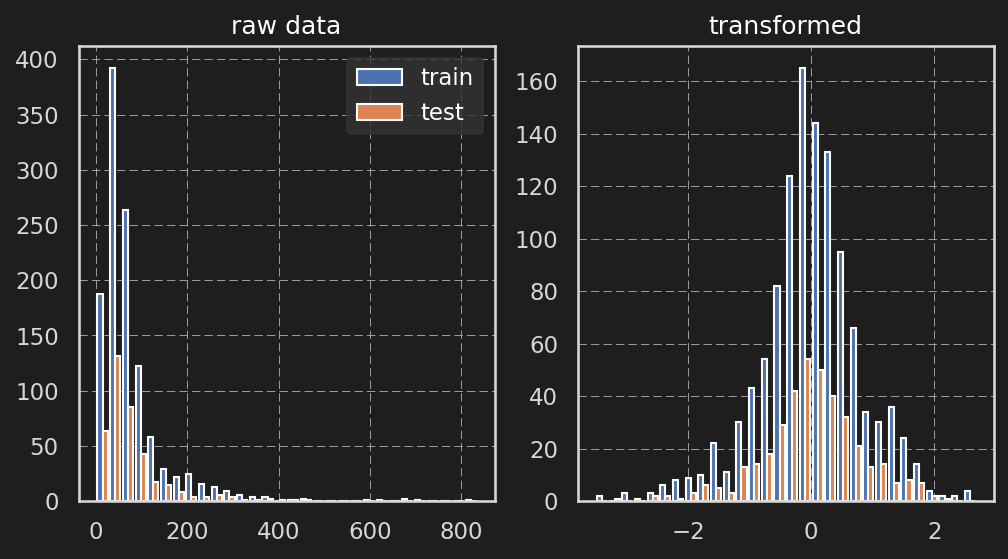

In [353]:
transformer = Transformer('log').fit( y )
fig, axs = plt.subplots( ncols=2, figsize=(20*cm, 10*cm))
axs[0].hist( (y_train, y_test), bins=30, label=['train','test'] )
axs[0].set_title('raw data')
# axs[1].hist( , bins=30 )
axs[1].hist( (transformer.transform(y_train),transformer.transform(y_test)), bins=30 )
axs[1].set_title('transformed')
axs[0].legend()


8


Text(0, 0.5, 'SSE')

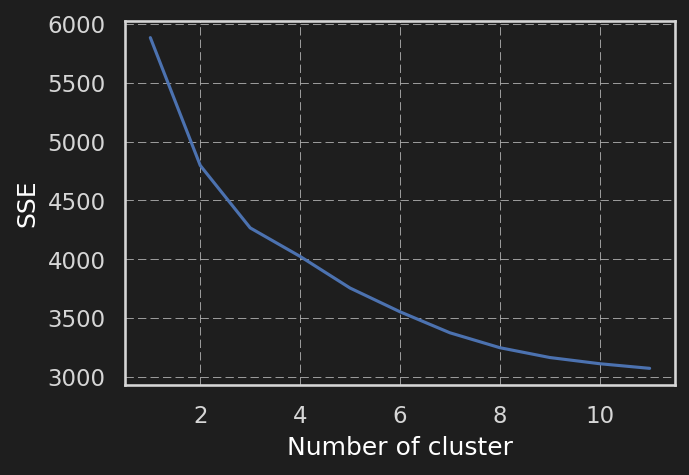

In [354]:
from sklearn.cluster import KMeans


print(n_continuous)
scaler_X = X_Scaler( n_scale_X ).fit( X )
Xi = scaler_X.transform( X )
Xi = np.hstack( (Xi, transformer.transform(y.values).reshape(-1,1)))
sse = {}
labels = {}
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(Xi)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    labels[k] = kmeans.labels_ # i mean of each element

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [355]:
if False:
    labels_y = labels[3]
    X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0, stratify=labels_y )
    y_train, y_test = y_train.values, y_test.values

    print('X', X.shape)
    print( 'X_train:', X_train.shape )

    print('Number of 0 in each colomn:')
    for i in range(X.shape[1]):
        prop_zeros_train = (X_train[:,i]==0).sum()/X_train.shape[0]
        prop_zeros_test = (X_test[:,i]==0).sum()/X_test.shape[0]
        print( '{:30}: train {:4.1%}, test {:4.1%}'.format( features_X[i], prop_zeros_train, prop_zeros_test) )

    dico_y = {'train':y_train, 'test':y_test}

***
# Definitions

Définition des modèles

In [356]:
modeles = {
    'dummy median': (dummy.DummyRegressor( ), {'strategy':['median']}),
    'elastic net':( linear_model.ElasticNet(random_state=0), 
                        {'l1_ratio':np.geomspace(0.5, 0.99, 10),
                        'alpha':np.logspace(-5, 1, 20)} ),
    'linear SVR': ( LinearSVR( dual=False ),
                        {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
                        'C':np.logspace(-5, 10, 20) } ),
    'kernel ridge polynomial':( kernel_ridge.KernelRidge(kernel='polynomial'),
                        {'alpha':np.logspace(-4, -2, 10),
                        'degree':[1,2,3,4],} ),
    'kernel ridge rbf':( kernel_ridge.KernelRidge(kernel='rbf'),
                        {'alpha':np.logspace(-6, 0, 10),
                        'gamma':np.logspace(-6, 0, 10),}),
    'kernel SVR rbf': ( SVR(kernel='rbf'),
                        {'C':np.logspace(-5, 4, 10),
                        'gamma':np.logspace(-5, -3, 10),} ),
    'random forest': ( RandomForestRegressor(),
                        {'n_estimators':[100, 200, 300, 400, 500],
                        'min_samples_split': [10, 20, 50],
                        'max_depth':[None, 5, 10]}),
    'light GBM': ( LGBMRegressor(),
                        {'n_estimators': [100, 200, 300, 400, 500],
                        'subsample': np.arange(0.1, 1.1, 0.1),
                        'learning_rate': [0.001, 0.01, 0.1, 1.0],
                        'max_depth': np.arange(2, 11, 2),} ),
}

# pour gagner en vitesse pour les premier essais
# _ = modeles.pop( 'kernel ridge rbf' )
# _ = modeles.pop( 'kernel SVR rbf' )
# _ = modeles.pop( 'random forest' )
# _ = modeles.pop( 'light GBM' )

Fonctions

In [357]:
def print_coefs( coefs, features ):
    n_features_0 = len( features )

    print('coefficients linear:')
    print(coefs[:n_features_0])

    if len( coefs ) > n_features_0:
        print('coefficients non-linear:')
        print(coefs[n_features_0:])

    print('linear coefs == 0 for :') #, np.array(features)[ coefs[:n_features_0+1] == 0. ])
    print('[', end='')
    for feature in np.array(features)[ coefs[:n_features_0] == 0. ]:
        print( f"'{feature}', ", end='')
    print(']')

    if len( coefs ) > n_features_0+1:
        print('non-linear coefs == 0 for :', np.array(features[1:])[ coefs[n_features_0+1:] == 0. ])

def histogram_per_coef( X, coefs, features ):
    y = (X @ coefs.reshape(-1,1)).ravel()
    for xi, coef, feature in zip( X.transpose(), coefs, features):
        fig, ax = plt.subplots( figsize=(12*cm,8*cm))
        ax.hist( xi*(coef*100)/y, bins=50 )
        ax.set_ylabel('count')
        ax.set_xlabel('influence sur la cible (%)')
        ax.set_title(feature)

def plot_results0( label, dico_results ):

    # argsort = y_test.argsort()
    # fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    # ax.plot( y_test[argsort], 'r', label='data' )
    # ax.plot( y_pred[argsort], 'bo', markersize=2, label=label )
    # ax.legend()
    # ax.set_xlabel('sample')

    fig, axs = plt.subplots( ncols=2, nrows=2, figsize=(20*cm,14*cm) )
    fig.suptitle( label )

    for i, dataset in enumerate( ['train', 'test'] ):
        y_pred = dico_results[label][ f'y_pred {dataset}' ]
        y = dico_y[dataset]
        ax = axs[0][i]
        ax.set_title( f'{dataset} set')
        ax.set_ylabel( 'prediction ' )
        ax.set_xlabel( 'target' )
        ax.plot( y, y_pred, 'bo', markersize=2 )
        xy_optim = [y.min(), y.max()]
        ax.plot( xy_optim, xy_optim, 'r', label='optimal fit' )
        # ax.legend()

        ax = axs[1][i]
        ax.hist( y_pred-y, bins=60 )
        ax.set_xlabel('Residual')
    fig.tight_layout()
    return

def model_to_results( name, model, training_time, dico_results ):
    dico_results[name] = {'y_pred test': model.predict(dico_X['test']),
                        'y_pred train': model.predict(dico_X['train']),
                        'training time': training_time,
                        'model':model }

def print_results0( dico_results ):
    scores = {
        'RMSE': lambda y_true,y_pred: np.sqrt(metrics.mean_squared_error(y_true,y_pred)),
        'R2 score': metrics.r2_score,
        }
    # index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
    #                                     + [('train',score) for score in scores]
    #                                     + [('test',score) for score in scores] )
    
    index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
                    + [(score,dataset) for score in scores for dataset in ['train', 'test'] ] )
    

    df_results = pd.DataFrame( index=index )
    for (name, results) in dico_results.items():
        df_results[name] = [results['training time']] \
            + [ score(dico_y[dataset], dico_results[name][ f'y_pred {dataset}']) for score in scores.values() for dataset in ['train', 'test'] ]
                        # + [ score(y_train_transformed, y_pred_train) for score in scores.values()] \
                        # + [ score(y_test_transformed, y_pred_test) for score in scores.values()]
    
    display( df_results.round(2) )

def print_results( dico_results ):
    print_results0( dico_results )
    print("{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement")
    for name in modeles:
        model = dico_results[name]['model']
        print('{:30} |'.format(name), ', '.join([ f'{param}: {value}' for param,value in model.best_params_.items() ]) )
        # print('\n\n|' + 20*'-' + '|\nModèle : {:}'.format(name) )
        # print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
        # print(model.best_params_)
        # plot_results( name, dico_results )
    return

def plot_results( dico_results ):
    for name in modeles:
        model = dico_results[name]['model']
        plot_results0( name, dico_results )
    return

In [358]:
def train_modeles( y_transformer ):
    dico_results = {}
    for name, (model, param_grid) in modeles.items():
        model = train_model( name, model, param_grid, y_transformer, dico_results )
    return dico_results

def train_model( model_name, model, param_grid, y_transformer, dico_results, score='r2' ): 
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    modelCV = model_selection.GridSearchCV(
        model, # modèle
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=score,   # score à optimiser
        n_jobs=-1
    )

    t0 = time.time()
    # modelCV.fit(dico_X['train'], dico_y['train'] )
    modelCV = model_with_y_transform( modelCV, y_transformer ).fit( dico_X['train'], dico_y['train'] )

    model_to_results( model_name, modelCV, time.time()-t0, dico_results )

    return modelCV

def print_y_describe():
    print('y:')
    columns = pd.MultiIndex.from_tuples( [('raw', 'train'), ('raw', 'test'), 
                                        ('transformed', 'train'), ('transformed', 'test')] )
    describe = pd.Series(y_train).describe()
    tmp = pd.DataFrame( index=describe.index, columns=columns )

    tmp[ 'raw', 'train' ] = describe
    describe = pd.Series(y_test).describe()
    tmp[ 'raw', 'test' ] = describe
    describe = pd.Series(dico_y['train']).describe()
    tmp[ 'transformed', 'train' ] = describe
    describe = pd.Series(dico_y['test']).describe()
    tmp[ 'transformed', 'test' ] = describe

    display( tmp.round(2).T )
    return

***
# Modélisations

## Données brutes

In [359]:
dico_X = {'train':X_train, 'test':X_test}

results_0 = train_modeles( Transformer('identity') )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+06, tolerance: 5.940e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+06, tolerance: 5.731e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

In [360]:
# print_y_describe()
print_results( results_0 )

dummy median  elastic net  linear SVR  \
         training time (sec.)          1.20         2.72        0.26   
RMSE     train                        81.80        59.13       59.28   
         test                         73.04        55.60       55.72   
R2 score train                        -0.08         0.44        0.43   
         test                         -0.09         0.37        0.37   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.39             12.33   
RMSE     train                                   49.52             57.70   
         test                                    54.65             55.28   
R2 score train                                    0.61              0.46   
         test                                     0.39              0.38   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)            6.46          70.79     123.44  
RMSE     train                          71.33          38.38      57.31  
         test                           61.71          53.12      57.54  
R2 score train                           0.18           0.76       0.47  
         test                            0.22           0.43       0.33

{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.00018329807108324357, l1_ratio: 0.6773625785352515
linear SVR                     | C: 784.7599703514622, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 1e-06, gamma: 4.641588833612782e-06
kernel SVR rbf                 | C: 10000.0, gamma: 0.001
random forest                  | max_depth: None, min_samples_split: 10, n_estimators: 500
light GBM                      | learning_rate: 0.01, max_depth: 6, n_estimators: 400, subsample: 0.1


## X scaled

In [361]:
scaler = X_Scaler( n_scale_X ).fit( X_train )

dico_X = scaler.scale_train_and_test( X_train, X_test )

results_1 = train_modeles( Transformer('identity') )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+06, tolerance: 6.049e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.069e+06, tolerance: 5.940e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

In [362]:
print_results( results_1 )

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         2.58        0.23   
RMSE     train                        81.80        59.13       59.12   
         test                         73.04        55.60       55.65   
R2 score train                        -0.08         0.44        0.44   
         test                         -0.09         0.37        0.37   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.42             12.57   
RMSE     train                                   51.08             54.23   
         test                                    53.76             53.79   
R2 score train                                    0.58              0.53   
         test                                     0.41              0.41   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)            5.03          57.21     111.65  
RMSE     train                          72.44          37.92      57.31  
         test                           61.17          53.68      57.44  
R2 score train                           0.16           0.77       0.47  
         test                            0.24           0.41       0.33

{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.00018329807108324357, l1_ratio: 0.6773625785352515
linear SVR                     | C: 20.6913808111479, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 2.1544346900318823e-05, gamma: 0.00046415888336127773
kernel SVR rbf                 | C: 10000.0, gamma: 0.001
random forest                  | max_depth: None, min_samples_split: 10, n_estimators: 200
light GBM                      | learning_rate: 0.01, max_depth: 6, n_estimators: 400, subsample: 0.1


## Y transformed

In [363]:
dico_X = {'train':X_train, 'test':X_test}

results_2 = train_modeles( Transformer('log') )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.952e+00, tolerance: 6.694e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+01, tolerance: 6.306e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

In [364]:
print_results( results_2 )

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.03         1.39        0.30   
RMSE     train                        81.80        65.49       71.45   
         test                         73.04        59.16       59.87   
R2 score train                        -0.08         0.31        0.18   
         test                         -0.09         0.29        0.27   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.62             13.02   
RMSE     train                                   56.16             64.05   
         test                                    64.56             58.82   
R2 score train                                    0.49              0.34   
         test                                     0.15              0.30   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)           22.37          59.11     112.89  
RMSE     train                          71.33          46.16      61.09  
         test                           59.95          54.78      60.73  
R2 score train                           0.18           0.66       0.40  
         test                            0.27           0.39       0.25

{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.0007847599703514606, l1_ratio: 0.8505690910211189
linear SVR                     | C: 3.359818286283781, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 1e-06, gamma: 1e-06
kernel SVR rbf                 | C: 10000.0, gamma: 0.0001291549665014884
random forest                  | max_depth: None, min_samples_split: 10, n_estimators: 300
light GBM                      | learning_rate: 0.01, max_depth: 8, n_estimators: 400, subsample: 0.1


In [365]:
dico_X = {'train':X_train, 'test':X_test}

results_2b = train_modeles( Transformer('power', power=1./6) )


100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/svm/_classes.py", line 518, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/thomas/Documents/Formations/OpenClassRoom

In [366]:
print_results( results_2b )

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         0.93        0.34   
RMSE     train                        81.80        63.31       64.27   
         test                         73.04        58.04       58.30   
R2 score train                        -0.08         0.35        0.33   
         test                         -0.09         0.31        0.31   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.35             12.41   
RMSE     train                                   53.67             62.42   
         test                                    59.40             57.57   
R2 score train                                    0.54              0.37   
         test                                     0.28              0.33   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)           29.15          58.63     113.33  
RMSE     train                          62.27          44.05      59.14  
         test                           58.61          53.24      58.93  
R2 score train                           0.38           0.69       0.44  
         test                            0.30           0.42       0.29

{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.000379269019073225, l1_ratio: 0.99
linear SVR                     | C: 3.359818286283781, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 1e-06, gamma: 1e-06
kernel SVR rbf                 | C: 10000.0, gamma: 4.641588833612782e-05
random forest                  | max_depth: None, min_samples_split: 10, n_estimators: 400
light GBM                      | learning_rate: 0.01, max_depth: 8, n_estimators: 400, subsample: 0.1


## X scaled and Y transformed

In [367]:
dico_X = scaler.scale_train_and_test( X_train, X_test )
results_3 = train_modeles( Transformer('log') )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+01, tolerance: 6.306e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.952e+00, tolerance: 6.694e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         1.33        0.32   
RMSE     train                        81.80        65.49       70.73   
         test                         73.04        59.15       60.09   
R2 score train                        -0.08         0.31        0.19   
         test                         -0.09         0.29        0.26   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.44             12.70   
RMSE     train                                   57.19             55.88   
         test                                    58.92             57.05   
R2 score train                                    0.47              0.50   
         test                                     0.29              0.34   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)            7.98          62.57     121.88  
RMSE     train                          67.39          46.58      60.96  
         test                           57.41          55.08      60.50  
R2 score train                           0.27           0.65       0.40  
         test                            0.33           0.38       0.25

{:30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.0007847599703514606, l1_ratio: 0.8505690910211189
linear SVR                     | C: 3.359818286283781, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 0.046415888336127725, gamma: 0.046415888336127725
kernel SVR rbf                 | C: 10000.0, gamma: 0.001
random forest                  | max_depth: None, min_samples_split: 10, n_estimators: 400
light GBM                      | learning_rate: 0.01, max_depth: 8, n_estimators: 400, subsample: 0.1


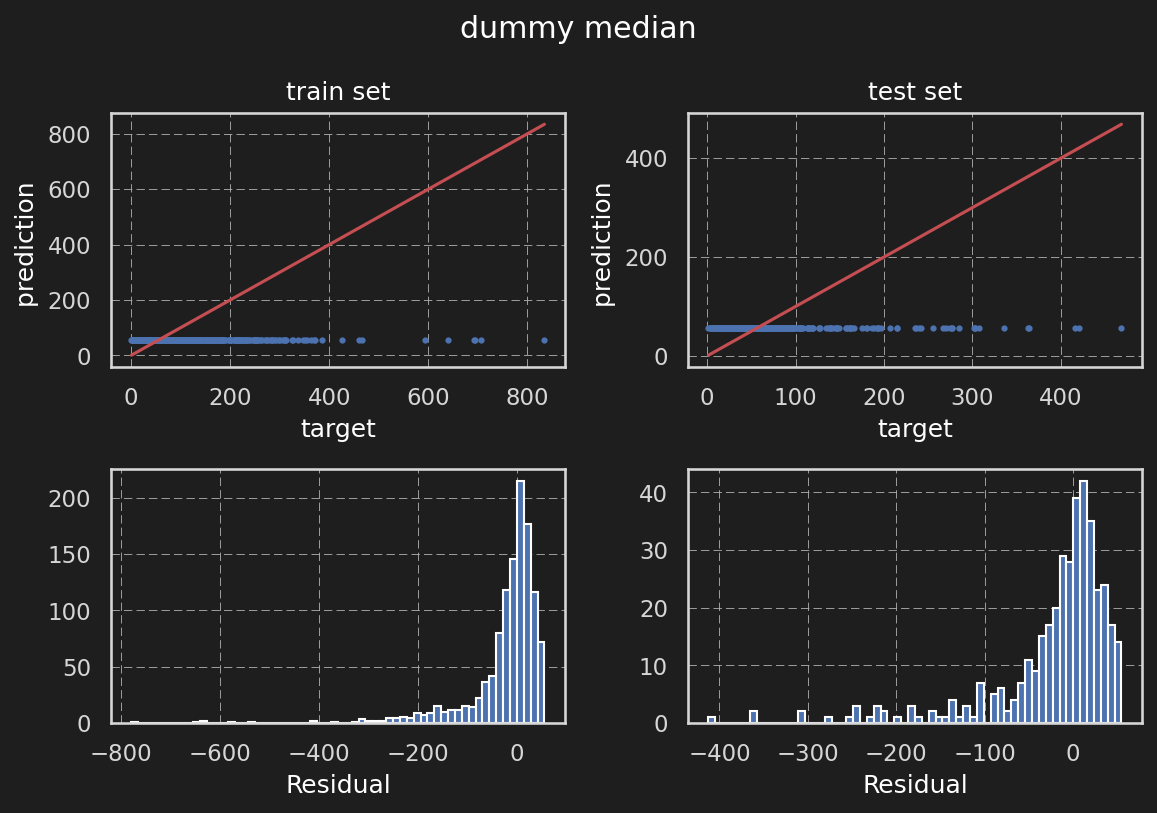

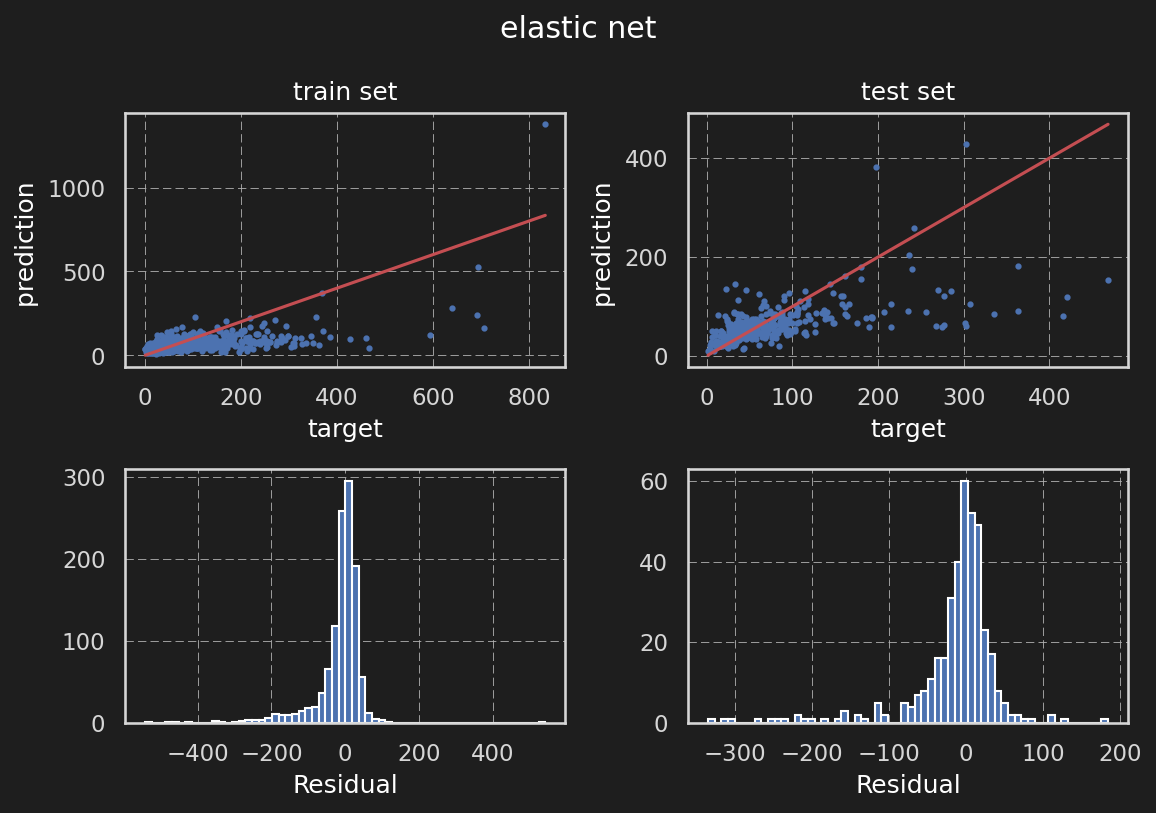

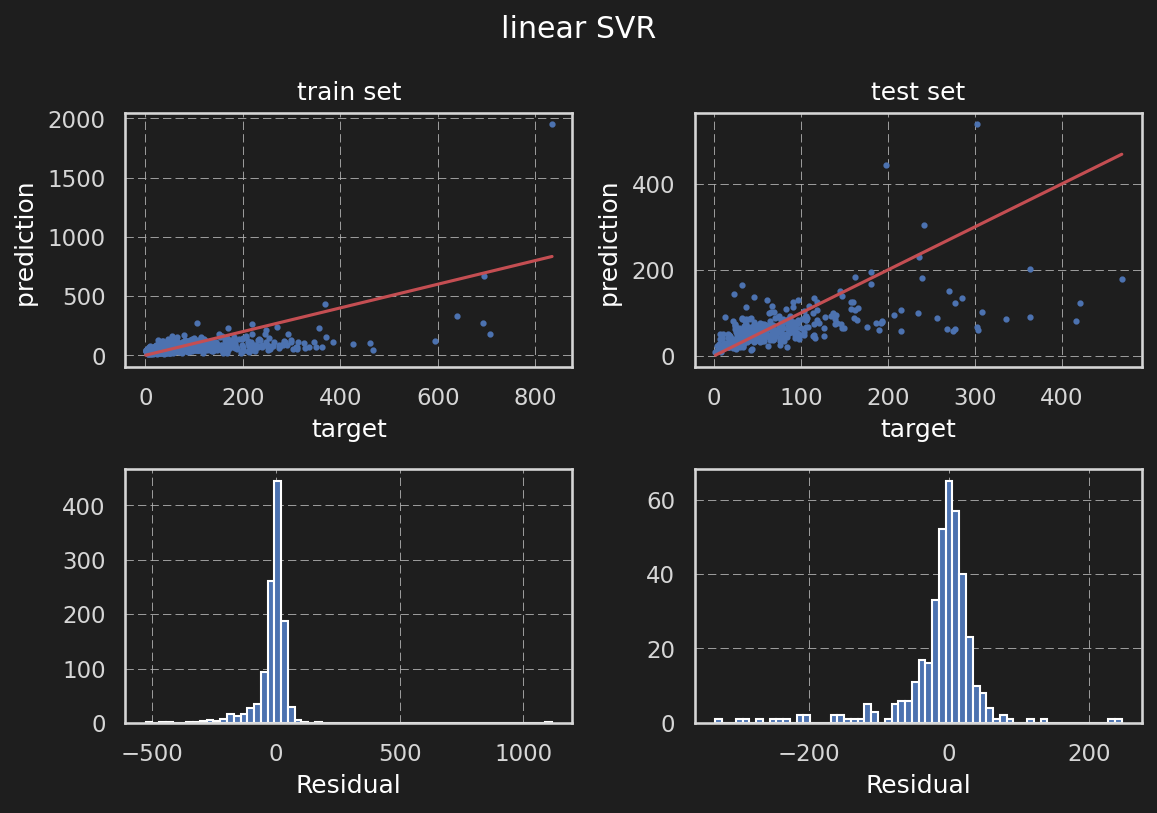

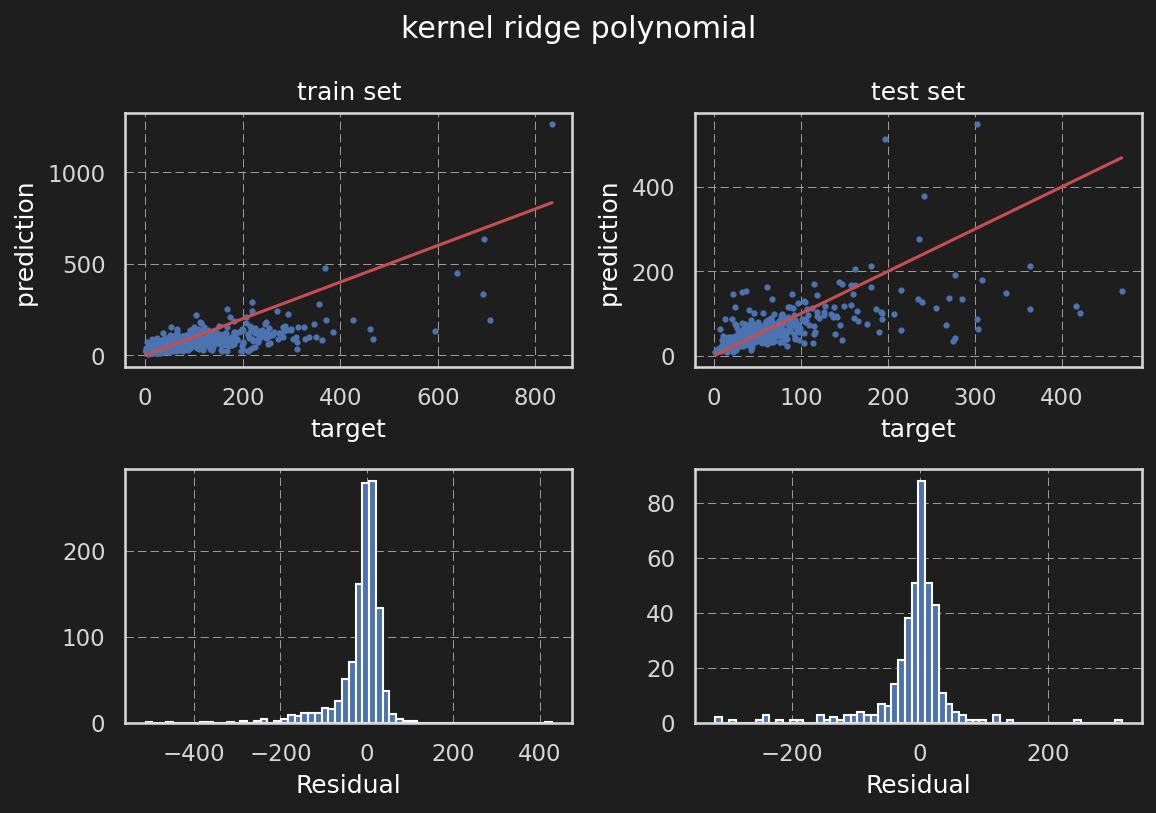

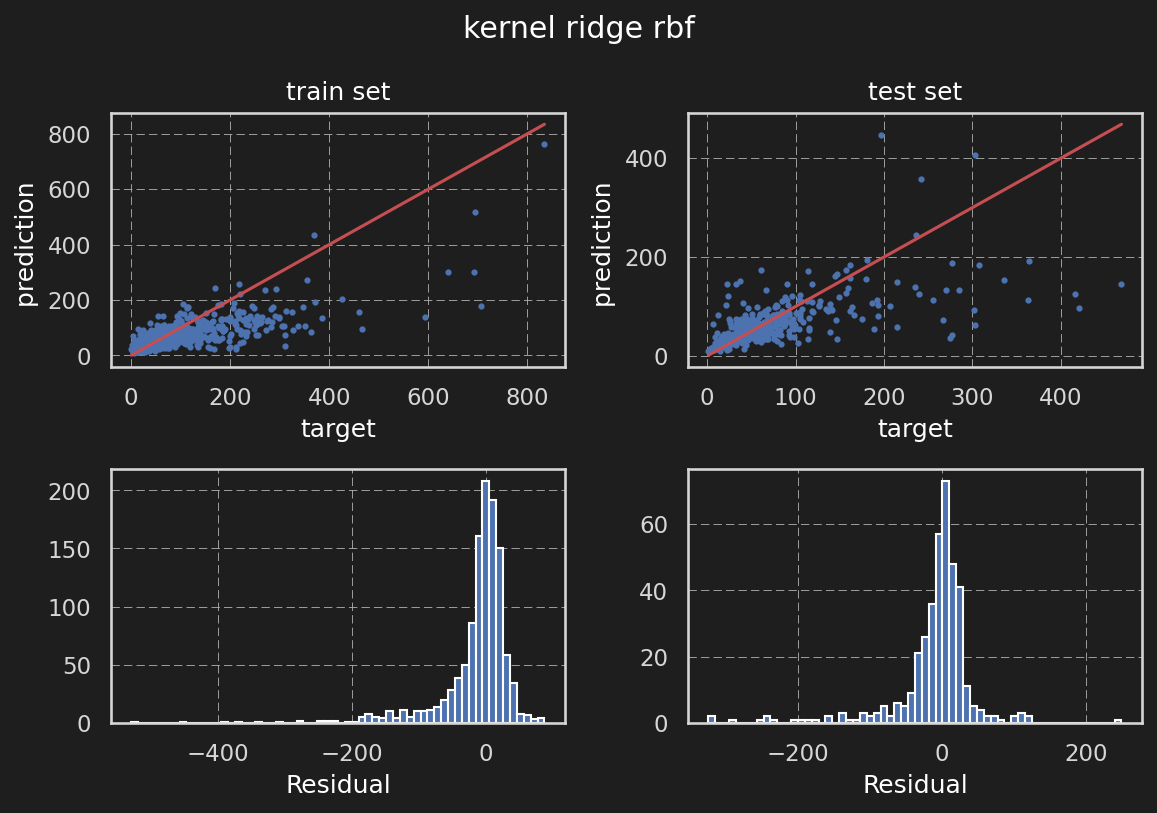

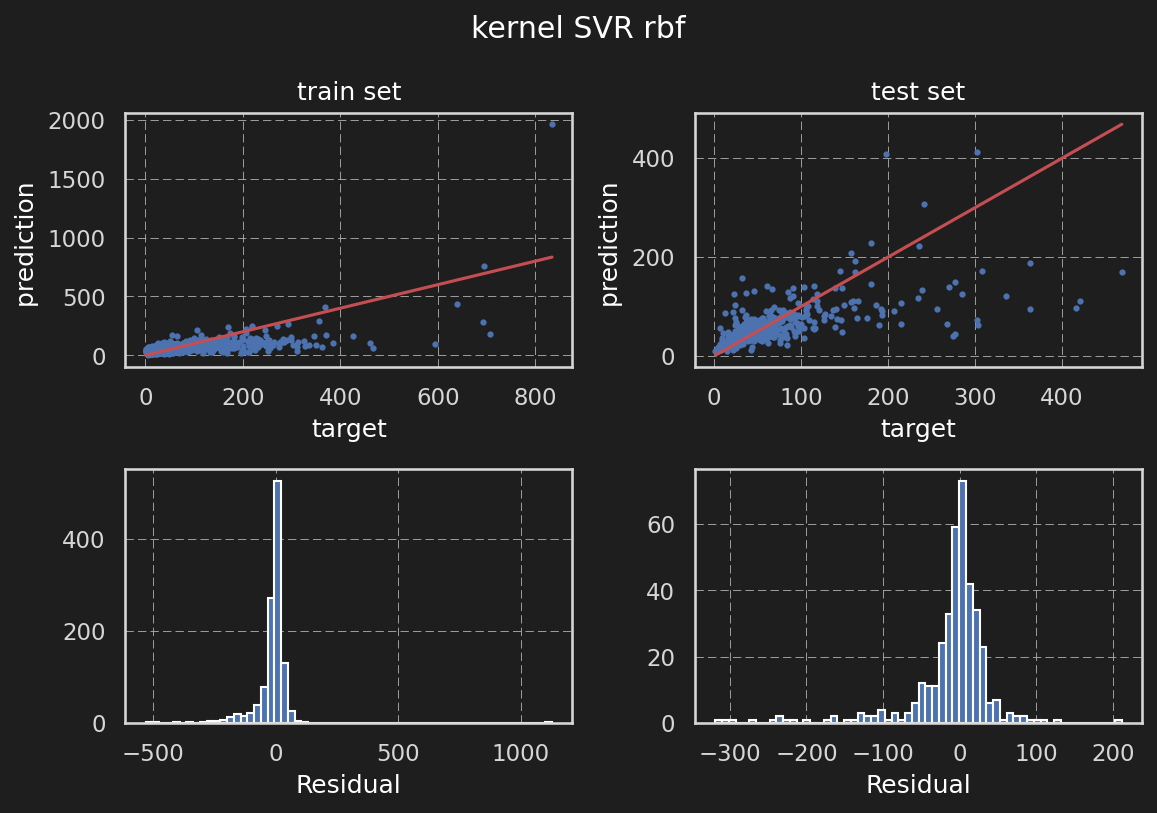

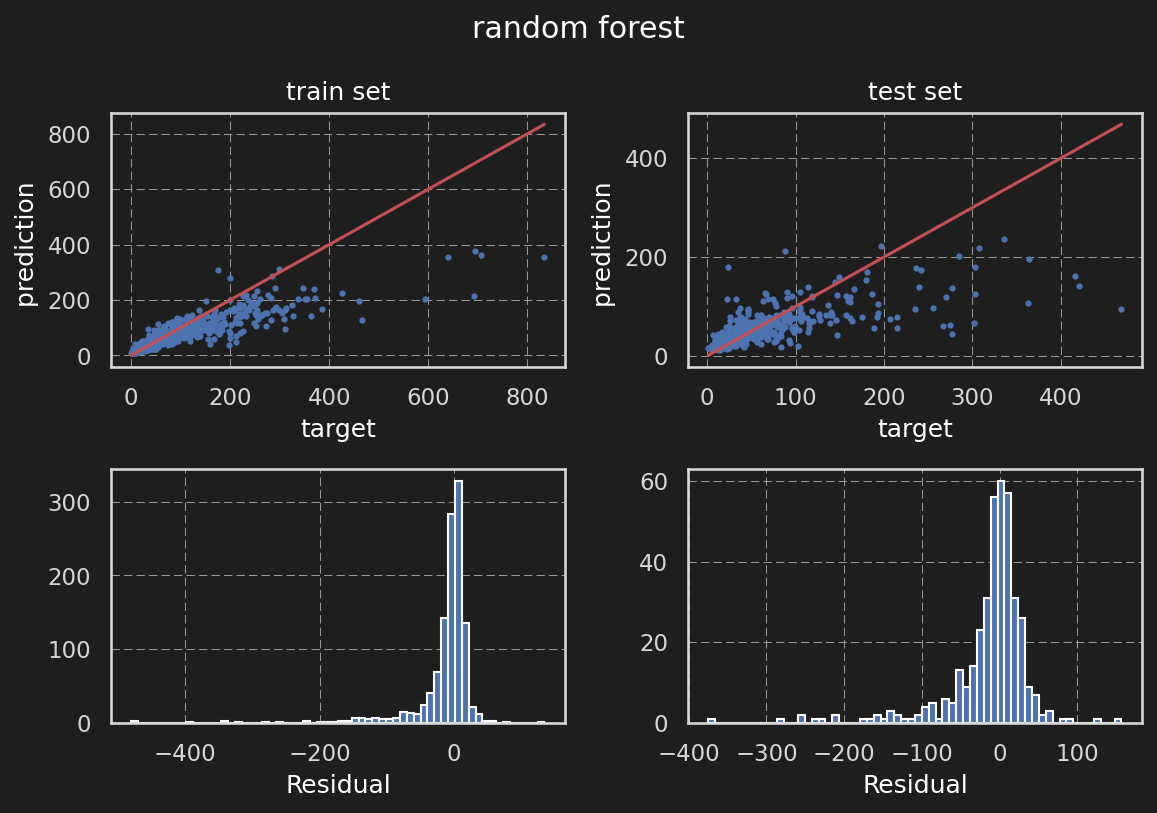

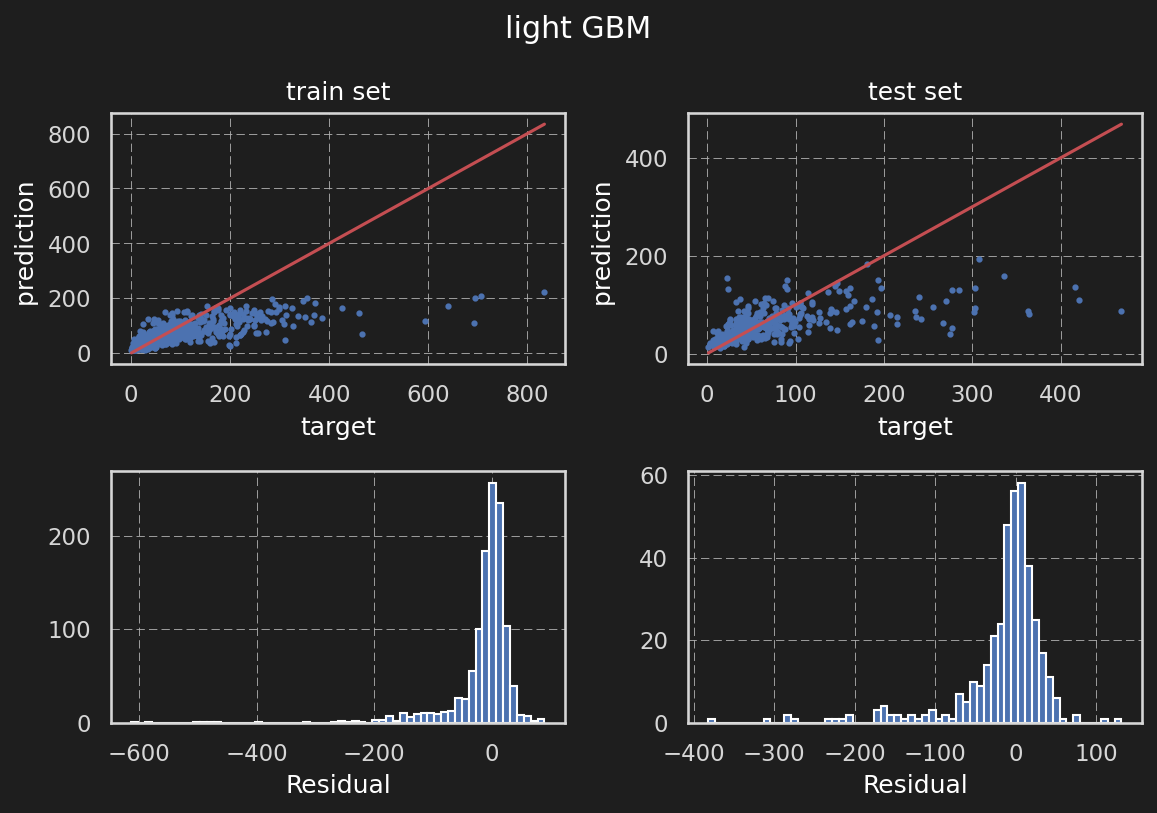

In [368]:
print_results( results_3 )
plot_results( results_3 )

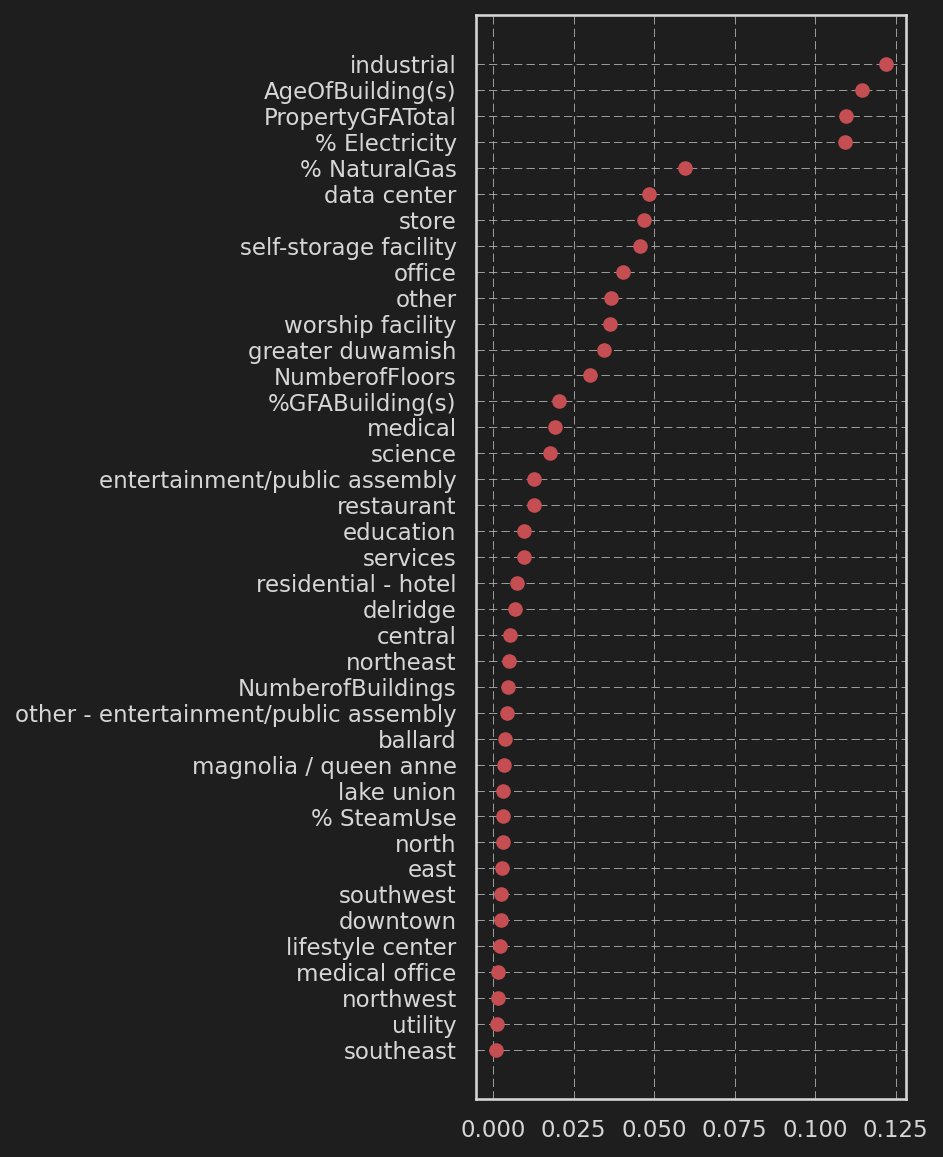

In [369]:
model = results_3['random forest']['model'].model.best_estimator_

fig, ax = plt.subplots(figsize=(16*cm,20*cm))
argsort = model.feature_importances_.argsort()
ax.plot( model.feature_importances_[argsort], np.array(features_X)[argsort], 'ro' )
fig.tight_layout()